In [39]:
import lightkurve as lk
import pbjam as pb
print(lk.__version__)
print(pb.__version__)
import pandas as pd
import os

1.4.0
0.1.8


In [46]:
ID = 'EPIC211409660'
try:
    os.mkdir(ID)
except:
    pass
lcs = lk.search_lightcurvefile(ID, mission='K2').download_all()

In [47]:
lcs

LightCurveFileCollection of 2 objects:
	EPIC 200200478 (1 KeplerLightCurveFiles) Campaigns: 16
	EPIC 200233389 (1 KeplerLightCurveFiles) Campaigns: 18

In [48]:
lc = lcs.PDCSAP_FLUX.stitch().flatten(window_length=4001).normalize('ppm').remove_outliers(5)

ValueError: This collection contains more than one target, please reduce to a single target before calling `stitch()`.

In [ ]:
lc.plot()

In [ ]:
pg = lc.to_periodogram(normalization='psd')

In [ ]:
pg.plot()

In [ ]:
pg.plot(scale='log')

In [8]:
df = pd.read_csv('../target_data.csv')
row = df.loc[df.ID == int(ID)]
print(row)
numax = [row.numax.values[0], row.numax_err.values[0]]
dnu = [row.dnu.values[0] * 1.01, row.dnu_err.values[0]]
teff = [row.teff.values[0], row.teff_err.values[0]]
bp_rp = [row.bp_rp.values[0], row.bp_rp_err.values[0]]
print(numax, dnu, teff, bp_rp)

          ID   dnu  dnu_err  numax  numax_err    teff  teff_err     bp_rp  \
8  141335100  9.63   0.0963  114.0       4.56  4617.0     92.34  1.384264   

   bp_rp_err  
8   0.069213  
[114.0, 4.5600000000000005] [9.7263, 0.0963] [4617.0, 92.34] [1.384264, 0.06921319999999999]


In [9]:
pg = lc.to_periodogram(normalization='psd',
                      minimum_frequency=numax[0] - dnu[0] * 4,
                      maximum_frequency=numax[0] + dnu[0] * 4).flatten()

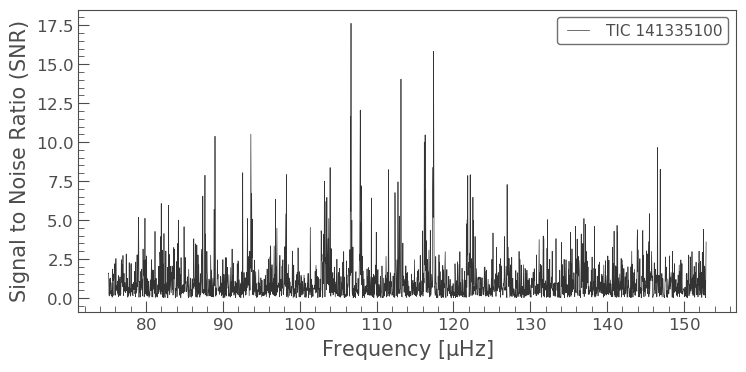

In [10]:
pg.plot()

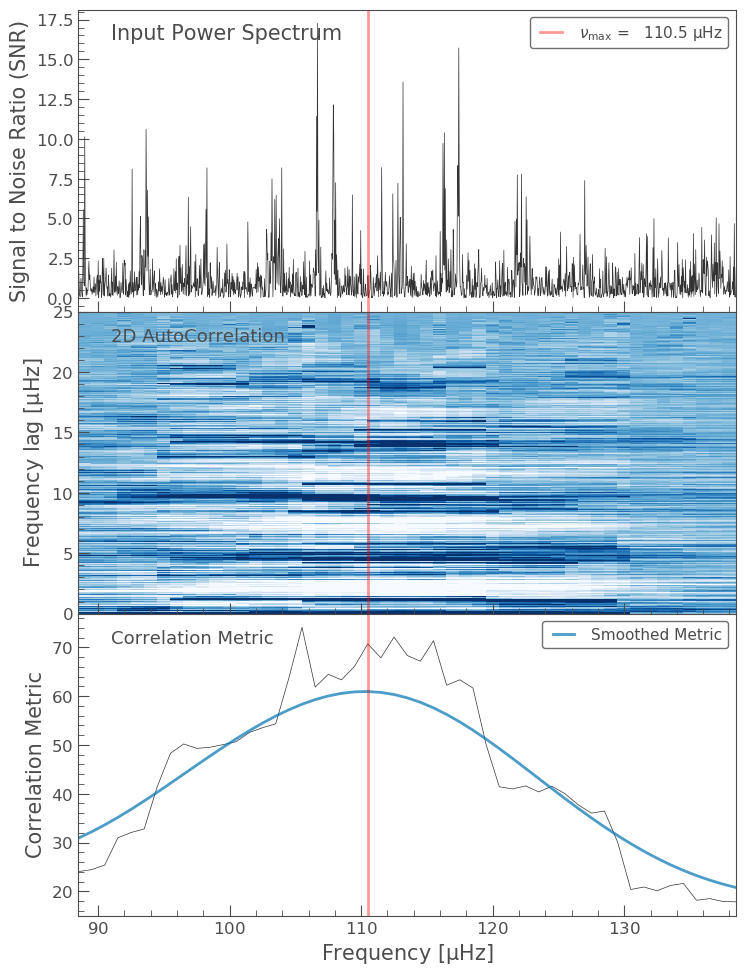

In [11]:
seismology = pg.flatten().to_seismology()
seismology.estimate_numax()
seismology.diagnose_numax();

In [14]:
try:
    seismology.estimate_deltanu()
    seismology.diagnose_deltanu()
    dnu[0] = seismology.deltanu.value
except ValueError:
    pass

dnu =  [9.6, 0.1]
numax =  [110.5, 4.5600000000000005]
{'l0': {}, 'l1': {}, 'l2': {}, 'l3': {}}


//anaconda3/lib/python3.7/site-packages/lightkurve/seismology/core.py:170: LightkurveWarning: You have passed both a numax and a frequency limit. The frequency limit will override the numax input.
  LightkurveWarning)


AttributeError: 'dict' object has no attribute 'nu'

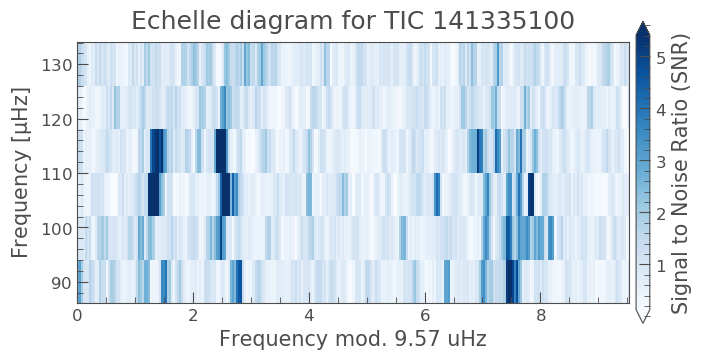

In [30]:
numax[0] = seismology.numax.value
dnu = [9.6, 0.1]
print('dnu = ', dnu)
print('numax = ', numax)
star = pb.star(ID, pg, numax, dnu, teff, bp_rp)
star.plot_echelle()

In [31]:
%%time
star.run_kde()

Starting KDE estimation
Steps taken: 2000
Steps taken: 3000
Chains reached stationary state after 3000 iterations.
CPU times: user 2min 21s, sys: 899 ms, total: 2min 22s
Wall time: 2min 18s


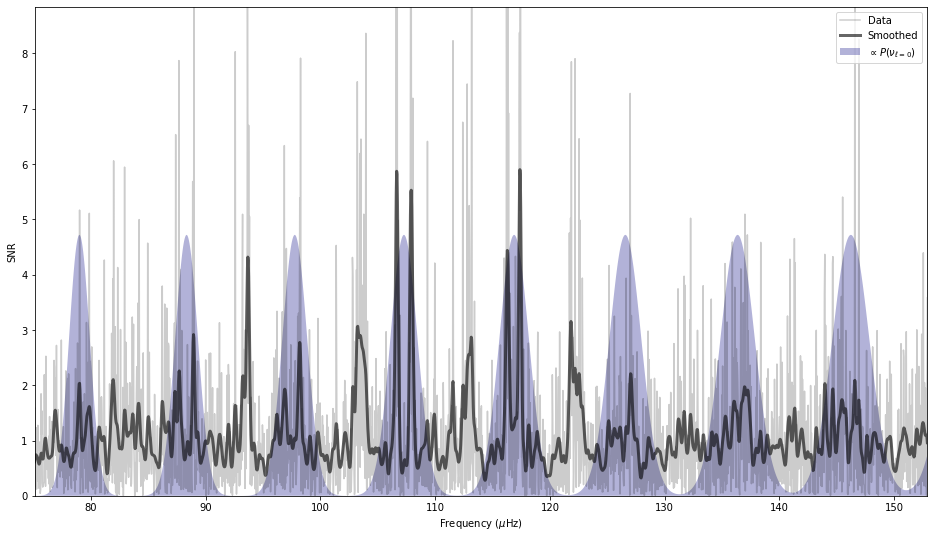

In [32]:
star.kde.plot_spectrum();

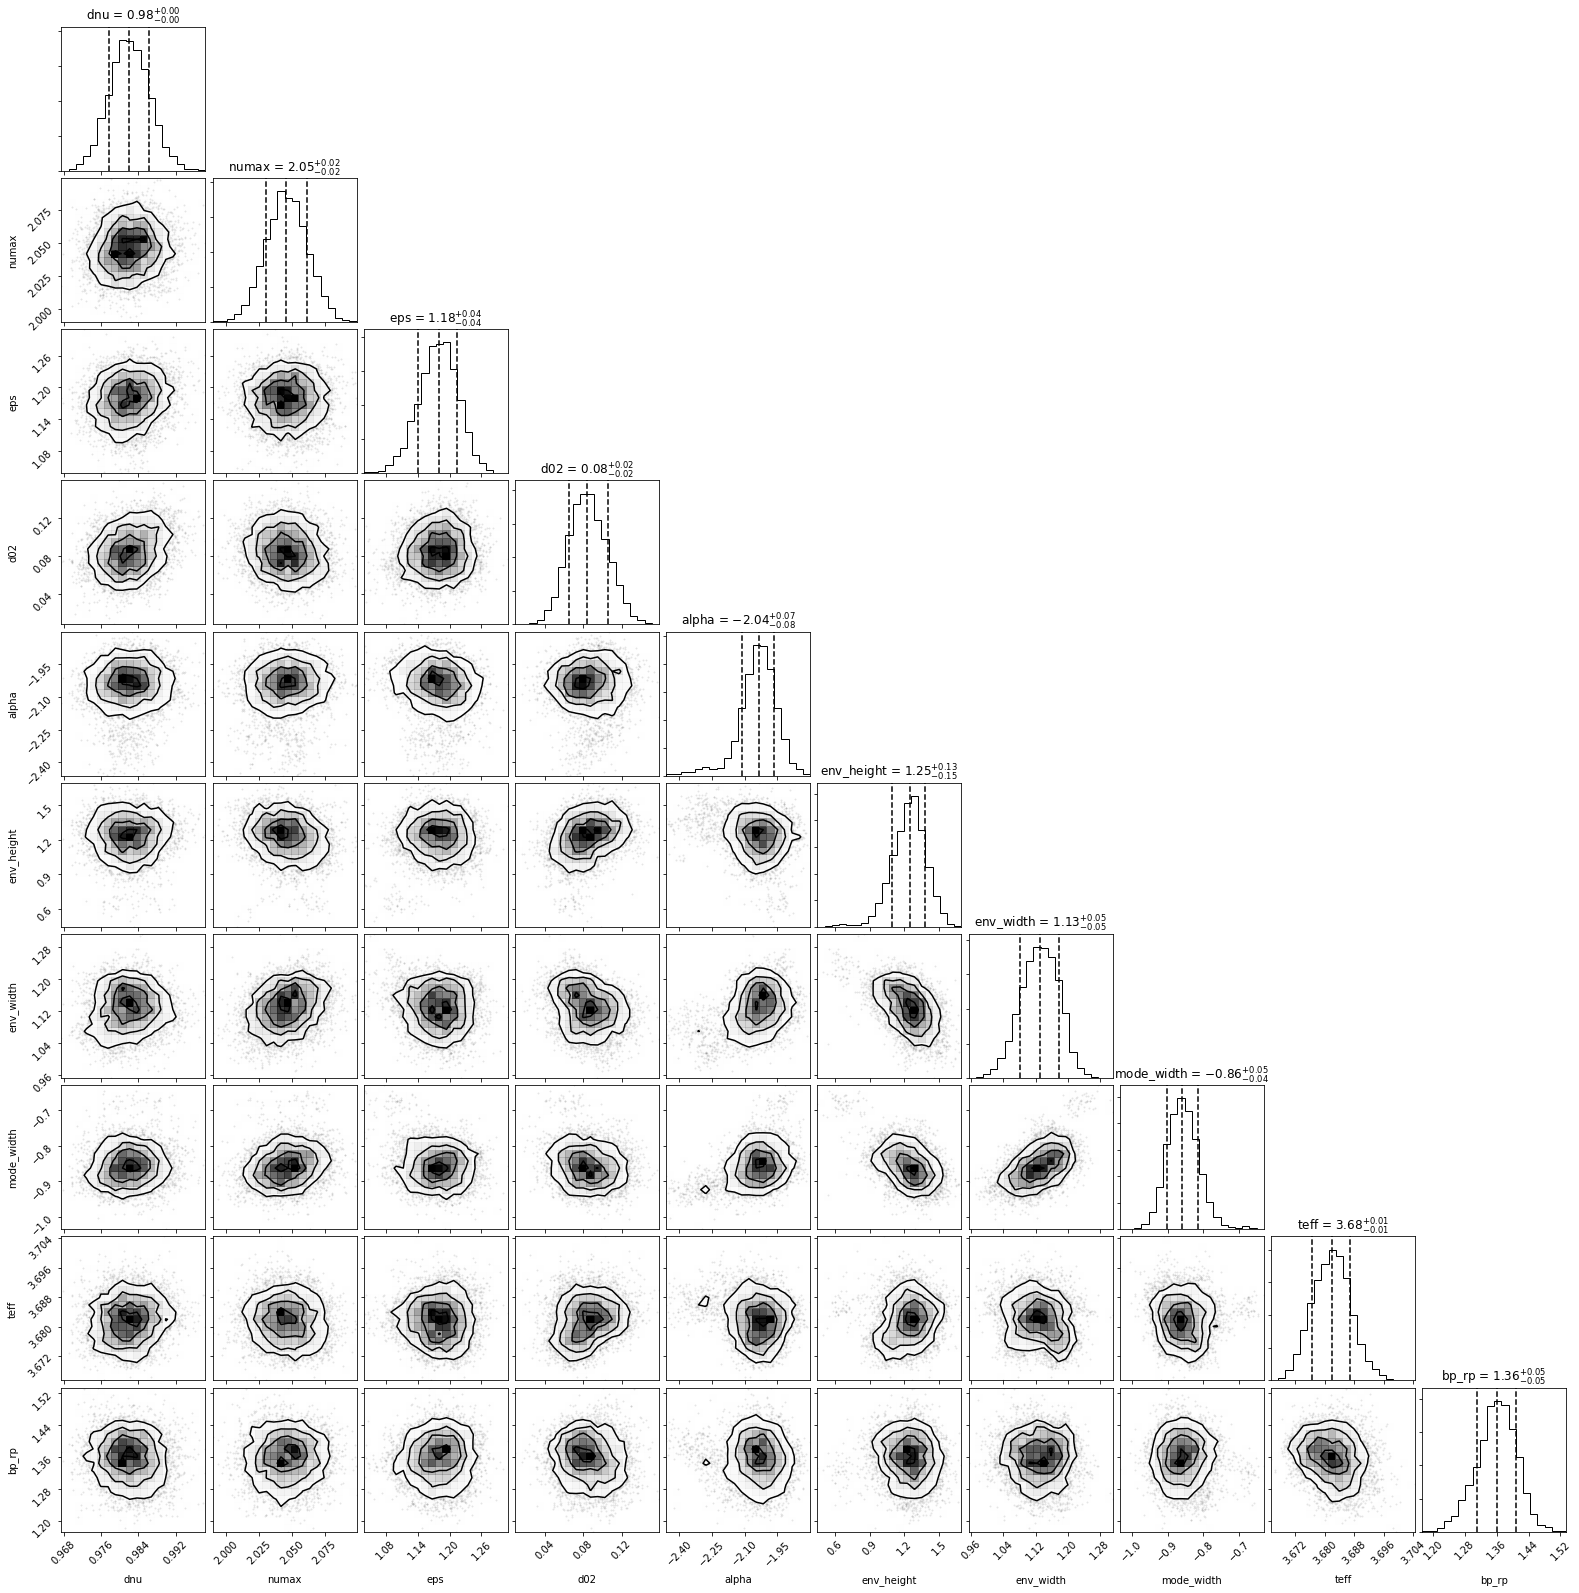

In [33]:
star.kde.plot_corner();

In [34]:
%%time
star.run_asy_peakbag(norders=8)

Starting Asy_peakbag
Steps taken: 2000
Steps taken: 3000
Steps taken: 4000
Chains reached stationary state after 4000 iterations.
CPU times: user 2min 13s, sys: 429 ms, total: 2min 13s
Wall time: 2min 9s


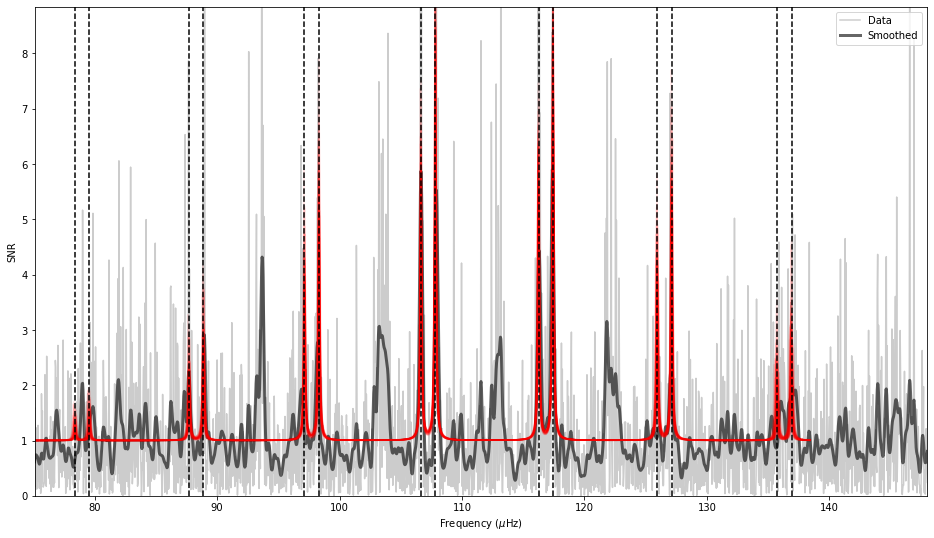

In [35]:
star.asy_fit.plot_spectrum();

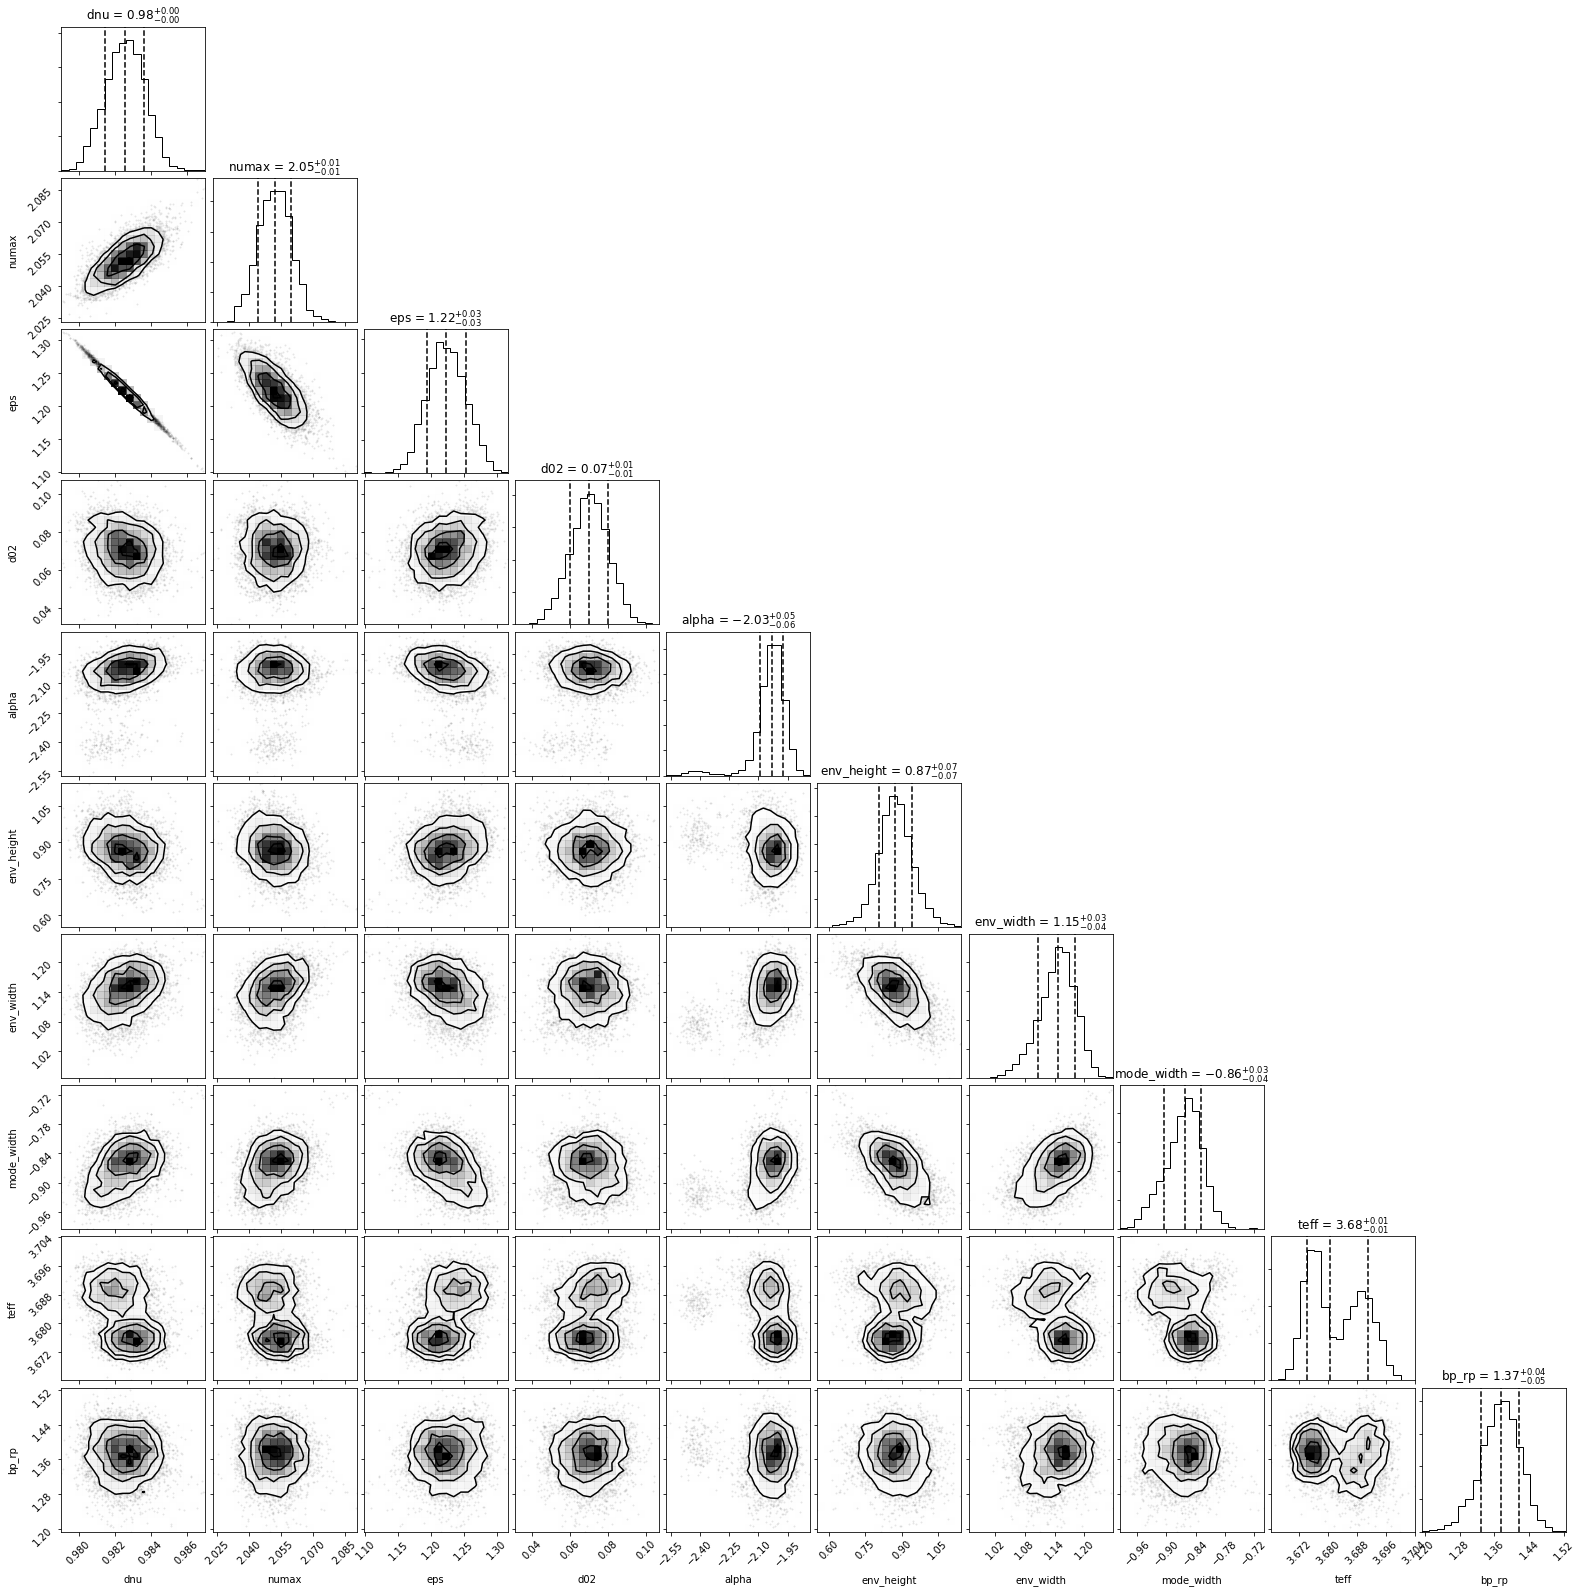

In [36]:
star.asy_fit.plot_corner();

In [37]:
%%time
star.run_peakbag()

Starting peakbagging run


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [back, height2, height0, l2, l0, width2, width0]
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 1min 12s, sys: 621 ms, total: 1min 13s
Wall time: 1min 17s


//anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


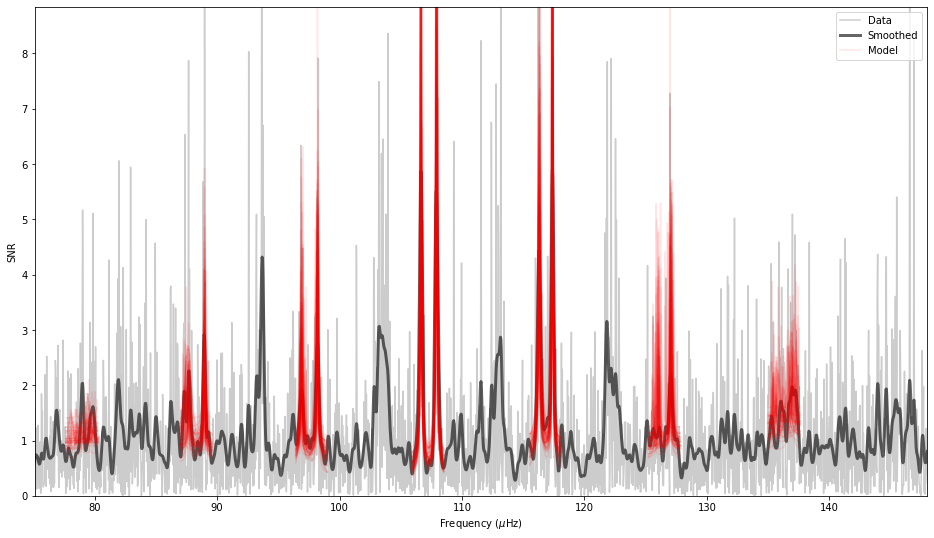

In [38]:
star.peakbag.plot_spectrum();

{'l0': {'nu': l0__0     79.591150
l0__1     88.965977
l0__2     98.205190
l0__3    107.918097
l0__4    117.392584
l0__5    127.045048
l0__6    137.004602
Name: mean, dtype: float64, 'err': l0__0    0.298295
l0__1    0.063563
l0__2    0.048601
l0__3    0.026433
l0__4    0.025400
l0__5    0.080260
l0__6    0.209935
Name: sd, dtype: float64}, 'l1': {'nu': Series([], Name: mean, dtype: float64), 'err': Series([], Name: sd, dtype: float64)}, 'l2': {'nu': l2__0     78.449515
l2__1     87.669388
l2__2     96.920279
l2__3    106.649249
l2__4    116.307543
l2__5    125.946174
l2__6    135.852079
Name: mean, dtype: float64, 'err': l2__0    0.340548
l2__1    0.256874
l2__2    0.101362
l2__3    0.028721
l2__4    0.041578
l2__5    0.251841
l2__6    0.307035
Name: sd, dtype: float64}, 'l3': {'nu': Series([], Name: mean, dtype: float64), 'err': Series([], Name: sd, dtype: float64)}}


//anaconda3/lib/python3.7/site-packages/lightkurve/seismology/core.py:170: LightkurveWarning: You have passed both a numax and a frequency limit. The frequency limit will override the numax input.
  LightkurveWarning)


AttributeError: 'dict' object has no attribute 'nu'

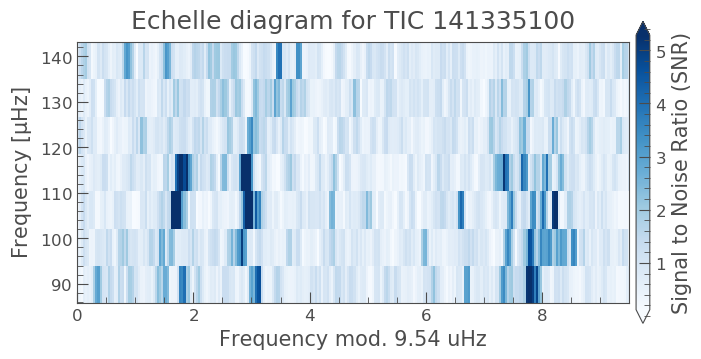

In [39]:
star.peakbag.plot_echelle()